# PSO Fitting Testing

In [1]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
import shapes

import matplotlib.pyplot as plt
import numpy as np

## Do 12-005 S2

Removing means (['M00: 572.78', 'M02: 118251.72', 'M11: 12787.84', 'M12: -142800.68', 'M20: 80173.9', 'M21: -112306.35', 'M22: 52262131.65']) 
Scaling standard deviations (['M00: 386.2', 'M02: 154667.97', 'M11: 124106.3', 'M12: 1342767.19', 'M20: 94607.6', 'M21: 1143759.61', 'M22: 145068970.21']) to be 1


<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

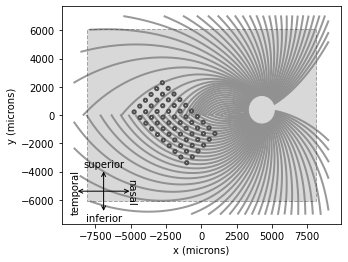

In [2]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2)
model.xystep=0.5

data = shapes.load_shapes("../data/shapes.h5", subjects=['12-005'], stim_class='SingleElectrode')
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']

img_shape = y[0].shape

estimator = shapes.BiphasicAxonMapEstimator(implant=implant, model=model, resize=True, mse_params=['moments_central'])
search_params = {
    'a5' : (0, 5),
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=100, has_loss_function=True)

y_moments = estimator.compute_moments(y)
model.build()
model.plot()
implant.plot()

In [3]:
estimator.score(x, y_moments)
opt.fit(x, y_moments)
estimator.score(x, y_moments)

score:12.540, rho:200.0, lambda:200.0, a5:1.081, a6:-0.353, empty:0, mses: ['M00:3.6', 'M02:1.9', 'M11:1.0', 'M12:1.0', 'M20:2.9', 'M21:1.0', 'M22:1.1']
score:9.847, rho:13.3, lambda:272.3, a5:2.940, a6:-2.675, empty:0, mses: ['M00:2.4', 'M02:1.6', 'M11:1.0', 'M12:1.0', 'M20:1.7', 'M21:1.0', 'M22:1.1']
score:1311103814.390, rho:959.7, lambda:1147.7, a5:4.213, a6:-4.266, empty:0, mses: ['M00:18929.2', 'M02:14894353.5', 'M11:9629.8', 'M12:32748059.1', 'M20:18682656.7', 'M21:5124354.8', 'M22:1239625831.3']
score:113676.599, rho:402.6, lambda:588.5, a5:3.545, a6:-3.431, empty:0, mses: ['M00:607.8', 'M02:17125.2', 'M11:9.4', 'M12:179.4', 'M20:41168.4', 'M21:72.0', 'M22:54514.4']
score:109234701.226, rho:856.1, lambda:1809.9, a5:2.691, a6:-2.364, empty:0, mses: ['M00:8524.3', 'M02:2857583.4', 'M11:5217.4', 'M12:1932925.1', 'M20:4846808.1', 'M21:1272138.8', 'M22:98311504.0']
score:16740.245, rho:328.7, lambda:846.8, a5:3.344, a6:-3.180, empty:0, mses: ['M00:292.9', 'M02:3737.2', 'M11:28.2', '

7.604203658426364

In [4]:
params1 = estimator.get_params()
params1

{'rho': 107.78254207801058,
 'axlambda': 640.0673562034946,
 'a0': 2.095,
 'a1': 0.054326,
 'a2': 1.84,
 'a3': 0.2,
 'a4': 3.0986,
 'a5': 0.38536581114212554,
 'a6': 0.518292736072343,
 'a7': 0.54,
 'a8': 0.21,
 'a9': 1.56}

score:7.688, rho:107.8, lambda:640.1, a5:0.385, a6:0.518, empty:0, mses: ['M00:1.3', 'M02:1.2', 'M11:0.9', 'M12:1.0', 'M20:1.2', 'M21:1.0', 'M22:1.1']


7.687942124398791

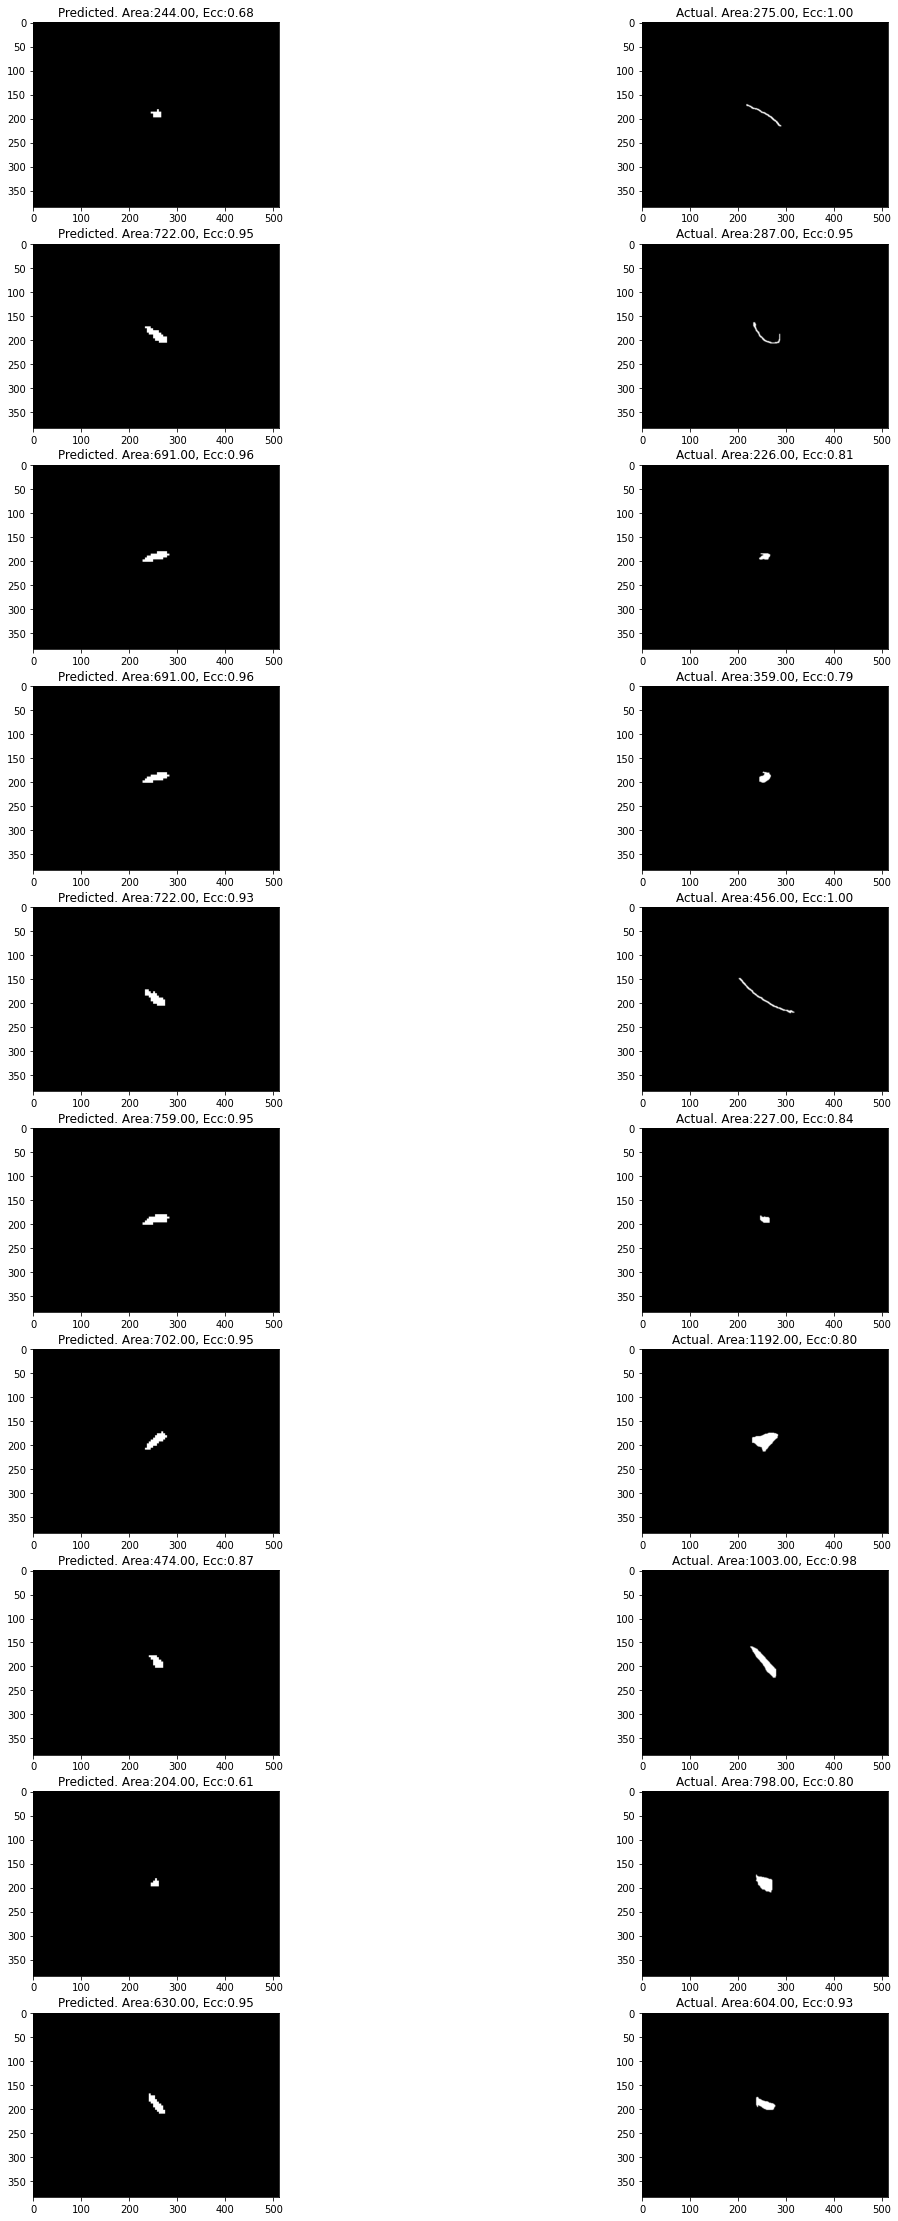

In [5]:
import random
from pulse2percept.utils import center_image, trim_image, scale_image
from skimage import measure
from skimage.transform import resize
fig, axes = plt.subplots(10, 2, figsize=(20, 40))
estimator.set_params(**params1)
estimator.fit(x, y)
preds = estimator.predict(x)
for plt_idx, img_idx in enumerate(random.sample([i for i in range(len(x))], 10)):
    img = resize(center_image(preds[img_idx] > (preds[img_idx].max() - preds[img_idx].min()) * 0.1 + preds[img_idx].min()), y[img_idx].shape)
    area = np.sum(img)
    axes[plt_idx, 0].imshow(img, cmap="gray")
    props = measure.regionprops(measure.label(img))
    axes[plt_idx, 0].set_title("Predicted. Area:%.2f, Ecc:%.2f" % (area, props[0].eccentricity))
    axes[plt_idx, 1].imshow(center_image(y[img_idx]), cmap='gray')
    props = measure.regionprops(measure.label(center_image(y[img_idx])))
    prop = max(props, key = lambda x : x.area)
    axes[plt_idx, 1].set_title("Actual. Area:%.2f, Ecc:%.2f" % (np.sum(center_image(y[img_idx])), prop.eccentricity))
fig.show()
estimator.score(x, y_moments)

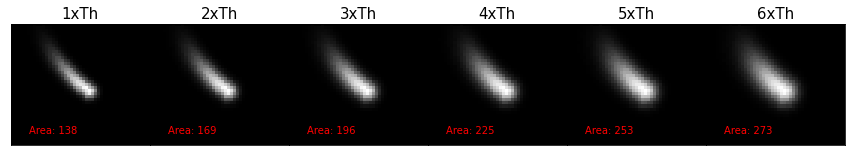

In [6]:
from pulse2percept.models import BiphasicAxonMapModel
from pulse2percept.stimuli import BiphasicPulseTrain, Stimulus
from pulse2percept.implants import ProsthesisSystem, DiskElectrode
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
font = {'fontname':'Arial'}

import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(1, 6, sharex=True, sharey=True)#, gridspec_kw={'height_ratios': [2.5, 1, 1]})
fig.subplots_adjust(wspace=0, hspace=-0.35)

amps = [1, 2, 3, 4, 5, 6]
freqs = [5, 10, 20,40, 80, 120]
pdurs_1 = [0.1, 0.5, 1, 5, 10]
pdurs_2 = [.1, 1, 5, 25, 50, 100]
# ticks = [-6.0, -3.0, 0.0, 3.0]
plotborder = 1.5
ticks = []
model = BiphasicAxonMapModel(axlambda=estimator.axlambda, rho=estimator.rho, do_thresholding=False, yrange=(0, 10), xrange=(-6.5, 5))
model.a5 = estimator.a5
model.a6 = estimator.a6
model.build()
implant = ProsthesisSystem(DiskElectrode(0, 1500, 10, 200))

for i, amp in enumerate(amps):
    ax = axes[i]
    fig.sca(ax)
    stim = BiphasicPulseTrain(5, amp, 0.45)
    implant.stim = stim
    percept = model.predict_percept(implant)
    percept.plot(figsize=(11.5 * 1.3, 10 * 1.3))
    ax.set_title("" + str(amp) + "xTh", fontsize=15, **font)
    if i != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("")
#         ax.set_ylabel("Amplitude", fontweight='bold', fontsize=14)
    ax.set_xlabel("")
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_ylim(0, 10)
    area = np.sum(percept.data > (percept.data.max() - percept.data.min()) * 0.1 + percept.data.min())
    ax.annotate("Area: {:d}".format(area), (-5, 1), color='r')

    
fig.show()

### Unstandardized mses

In [4]:
estimator.mse_params = ['moments_central', "area", "eccentricity", "major_axis_length", "minor_axis_length", "orientation"]
estimator.scale_features = False
new_y_moments = estimator.compute_moments(y, fit_scaler=False)
estimator.score(x, new_y_moments)

Warning, got different length feature_importances and mse_params. Did you set one manually?
Defaulting to equal weighting
score=11791400626093288.000, rho=200.0, lambda=200.0, a5=1.081, a6=-0.353, mses: ['M00: 547970.197', 'M02: 37707208160.562', 'M11: 8851765103.171', 'M12: 175017656640.709', 'M20: 23336645998.738', 'M21: 106765878002.187', 'M22: 1.1791048945841724e+16', 'area: 547970.197', 'eccentricity: 0.229', 'major_axis_length: 1371.235', 'minor_axis_length: 346.584', 'orientation: 1.003']


1.1791400626093288e+16

### Standardized mses

In [6]:
estimator.mse_params = ['moments_central', "area", "eccentricity", "major_axis_length", "minor_axis_length", "orientation"]
estimator.scale_features=True
new_y_moments = estimator.compute_moments(y, fit_scaler=True)
estimator.score(x, new_y_moments)

Removing means (['M00: 560.18', 'M02: 95102.63', 'M11: 24202.46', 'M12: -46893.36', 'M20: 65115.72', 'M21: -50567.79', 'M22: 31353163.63', 'area: 560.18', 'eccentricity: 0.87', 'major_axis_length: 58.04', 'minor_axis_length: 18.48', 'orientation: 0.06']) 
Scaling standard deviations (['M00: 392.19', 'M02: 130835.05', 'M11: 93802.57', 'M12: 416635.68', 'M20: 76773.64', 'M21: 322264.26', 'M22: 102740688.22', 'area: 392.19', 'eccentricity: 0.15', 'major_axis_length: 29.93', 'minor_axis_length: 9.21', 'orientation: 0.94']) to be 1
score=33.902, rho=200.0, lambda=200.0, a5=1.081, a6=-0.353, mses: ['M00: 3.563', 'M02: 2.203', 'M11: 1.006', 'M12: 1.008', 'M20: 3.959', 'M21: 1.028', 'M22: 1.117', 'area: 3.563', 'eccentricity: 9.699', 'major_axis_length: 1.531', 'minor_axis_length: 4.082', 'orientation: 1.143']


33.90164057294065

## Fit size model first

In [1]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
import shapes

import matplotlib.pyplot as plt
import numpy as np

Removing means (['M00: 572.78', 'M02: 118251.72', 'M11: 12787.84', 'M12: -142800.68', 'M20: 80173.9', 'M21: -112306.35', 'M22: 52262131.65']) 
Scaling standard deviations (['M00: 386.2', 'M02: 154667.97', 'M11: 124106.3', 'M12: 1342767.19', 'M20: 94607.6', 'M21: 1143759.61', 'M22: 145068970.21']) to be 1
a5=0.215281, a6=0.730899


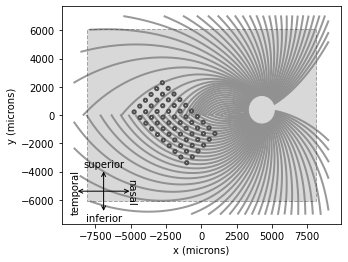

In [2]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2)
model.xystep=0.5

data = shapes.load_shapes("../data/shapes.h5", subjects=['12-005'], stim_class='SingleElectrode')
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']

img_shape = y[0].shape

estimator = shapes.BiphasicAxonMapEstimator(implant=implant, model=model, resize=True, mse_params=['moments_central'])
search_params = {
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=100, has_loss_function=True)

y_moments = estimator.compute_moments(y)
model.build()
model.plot()
implant.plot()
estimator.fit_size_model(x['amp1'], y)

In [ ]:
estimator.score(x, y_moments)
opt.fit(x, y_moments)
estimator.score(x, y_moments)

In [3]:
estimator.rho = 20
estimator.fit(x, y_moments)
estimator.score(x, y_moments)

[]
score:10.005, rho:20.0, lambda:200.0, a5:0.215, a6:0.731, empty:0, mses: ['M00:2.6', 'M02:1.6', 'M11:1.0', 'M12:1.0', 'M20:1.7', 'M21:1.0', 'M22:1.1']


10.00527611453534

In [13]:
imgs = estimator.predict(x)
props = [estimator.get_props(p, threshold="compute") for p in imgs]

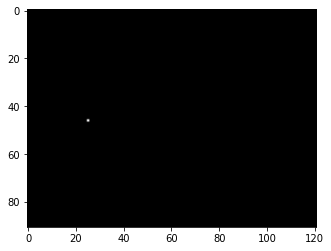

In [5]:
plt.imshow(imgs[80], cmap='gray')

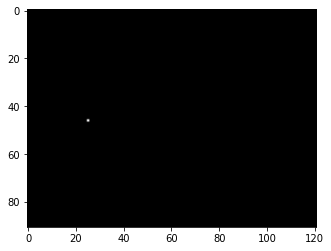

In [7]:
thresholded = imgs[80] > (imgs[80].max() - imgs[80].min()) * 0.1 + imgs[80].min()
plt.imshow(thresholded, cmap='gray')

In [19]:
import skimage.measure as measure
moms = measure.moments_central(thresholded)
feats = [moms[0,0], moms[0, 2], moms[1,1], moms[1,2], moms[2,0], moms[2,1], moms[2,2]]
feats

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [9]:
list(estimator.scaler.mean_)

[572.7795566502463,
 118251.72248742142,
 12787.841040704705,
 -142800.67899861984,
 80173.89579116872,
 -112306.3537144008,
 52262131.64597624]

In [10]:
list(estimator.scaler.transform(np.array(feats).reshape(1, -1))[0])

[-1.480544030000963,
 -0.7645520851754347,
 -0.10303941757870522,
 0.10634805482459317,
 -0.8474361048106994,
 0.09819052226447433,
 -0.3602571354138223]

In [21]:
y_img = imgs[80] 
threshold = (y_img.max() - y_img.min()) * 0.1 + y_img.min()
central_moments = measure.moments_central(y_img > threshold)
central_moments

array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [24]:
prop_moments = []
for r in range(3):
    for c in range(3):
        if r + c != 1:
            prop_moments.append(central_moments[r,c])
feats = np.array(prop_moments)
feats

array([1., 0., ..., 0., 0.])

In [27]:
list(estimator.scaler.transform(feats.reshape(1, -1))[0])

[-1.4869670554695333,
 -0.7645570283583216,
 -0.10304024782999949,
 0.10634813402525835,
 -0.8474450621894652,
 0.09819060811338975,
 -0.36025713789717306]

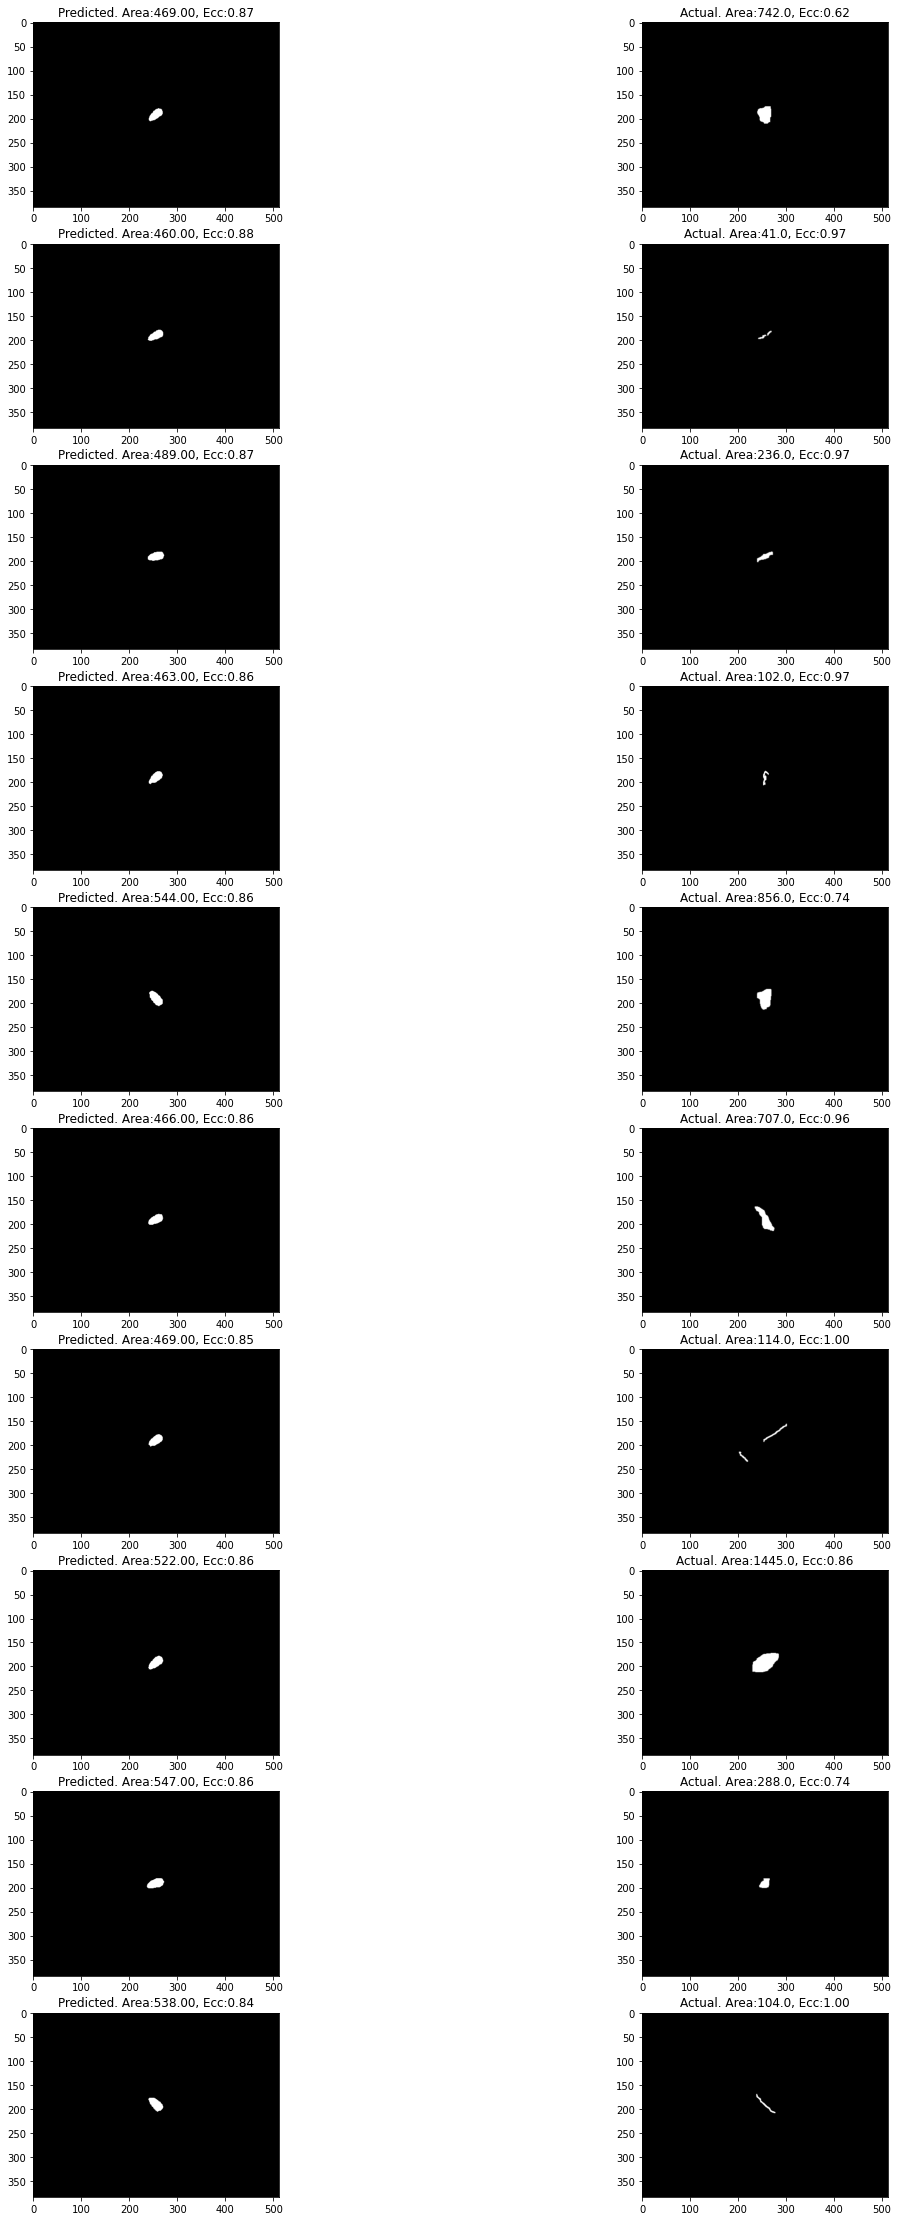

In [13]:
import random
from pulse2percept.utils import center_image, trim_image, scale_image
from skimage import measure
from skimage.transform import resize
fig, axes = plt.subplots(10, 2, figsize=(20, 40))
preds = estimator.predict(x)
for plt_idx, img_idx in enumerate(random.sample([i for i in range(len(x))], 10)):
    axes[plt_idx, 0].imshow(resize(center_image(preds[img_idx] > 1), y[img_idx].shape), cmap="gray")
    props = measure.regionprops(measure.label(resize(center_image(preds[img_idx] > 1), y[img_idx].shape)))
    axes[plt_idx, 0].set_title("Predicted. Area:%.2f, Ecc:%.2f" % (props[0].area, props[0].eccentricity))
    axes[plt_idx, 1].imshow(center_image(y[img_idx]), cmap='gray')
    props = measure.regionprops(measure.label(center_image(y[img_idx])))
    prop = max(props, key = lambda x : x.area)
    axes[plt_idx, 1].set_title("Actual. Area:%.2f, Ecc:%.2f" % (prop.area, prop.eccentricity))
fig.show()
estimator.score(x, y_moments)

## AxonMap

In [16]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
import shapes

import matplotlib.pyplot as plt
import numpy as np

Removing means (['M00: 572.78', 'M02: 118251.72', 'M11: 12787.84', 'M12: -142800.68', 'M20: 80173.9', 'M21: -112306.35', 'M22: 52262131.65']) 
Scaling standard deviations (['M00: 386.2', 'M02: 154667.97', 'M11: 124106.3', 'M12: 1342767.19', 'M20: 94607.6', 'M21: 1143759.61', 'M22: 145068970.21']) to be 1


<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

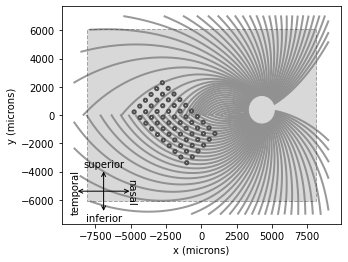

In [17]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2, biphasic=False)
model.xystep=0.5

data = shapes.load_shapes("../data/shapes.h5", subjects=['12-005'], stim_class='SingleElectrode')
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']

img_shape = y[0].shape

estimator = shapes.AxonMapEstimator(implant=implant, model=model, resize=True, mse_params=['moments_central'])
search_params = {
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=100, has_loss_function=True)

y_moments = estimator.compute_moments(y)
model.build()
model.plot()
implant.plot()

In [18]:
estimator.score(x, y_moments)
opt.fit(x, y_moments)
estimator.score(x, y_moments)

score:7.644, rho:200.0, lambda:200.0, empty:0, mses:['M00:1.1', 'M02:1.2', 'M11:1.0', 'M12:1.0', 'M20:1.2', 'M21:1.0', 'M22:1.1']
score:1588.131, rho:307.1, lambda:1903.5, empty:0, mses:['M00:78.7', 'M02:504.5', 'M11:196.2', 'M12:63.0', 'M20:302.1', 'M21:125.4', 'M22:318.2']
score:7.673, rho:142.9, lambda:396.6, empty:0, mses:['M00:1.1', 'M02:1.3', 'M11:0.9', 'M12:1.0', 'M20:1.3', 'M21:1.0', 'M22:1.1']
score:53431.633, rho:748.9, lambda:1931.1, empty:0, mses:['M00:927.3', 'M02:16357.0', 'M11:1435.2', 'M12:3289.7', 'M20:13734.9', 'M21:1872.9', 'M22:15814.6']
score:1833.348, rho:625.0, lambda:400.3, empty:0, mses:['M00:222.2', 'M02:461.6', 'M11:1.8', 'M12:2.5', 'M20:1076.6', 'M21:2.4', 'M22:66.2']
score:62.826, rho:106.6, lambda:1711.5, empty:0, mses:['M00:5.1', 'M02:20.2', 'M11:11.0', 'M12:4.0', 'M20:9.1', 'M21:5.8', 'M22:7.6']
score:24878.440, rho:885.3, lambda:197.0, empty:0, mses:['M00:868.5', 'M02:5739.5', 'M11:1.0', 'M12:1.3', 'M20:15163.0', 'M21:1.7', 'M22:3103.5']
score:307.884, 

KeyboardInterrupt: 